In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

In [2]:
df=pd.read_csv('desktop/new_folder/train.csv')
df_t=pd.read_csv('desktop/new_folder/test.csv')

In [3]:
le = preprocessing.LabelEncoder()
le.fit(df.Severity.values)
d=le.transform(df.Severity.values)
label=df.Severity.values
df.Severity=pd.Series(d)

In [4]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(df,2,df.columns.values)

In [5]:
# Drop outliers
df = df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
label=df.Severity.values

In [6]:
df2=df.drop(columns=['Severity','Accident_ID'])
#df2['Total_Safety_Complaints'] = np.power(2, df2['Total_Safety_Complaints'])
#df2['Days_Since_Inspection'] = np.power(2, df2['Days_Since_Inspection'])
#df2['Safety_Score'] = np.power(2, df2['Safety_Score'])
IDtest=df_t['Accident_ID'].values
df_t=df_t.drop(columns=['Accident_ID'])
#df_t['Total_Safety_Complaints'] = np.power(2, df_t['Total_Safety_Complaints'])
#df_t['Days_Since_Inspection'] = np.power(2, df_t['Days_Since_Inspection'])
#df_t['Safety_Score'] = np.power(2, df_t['Safety_Score'])
quantile_transformer = preprocessing.StandardScaler()
X_trans = quantile_transformer.fit_transform(df2)
X_test = quantile_transformer.transform(df_t)

C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Lenovo\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


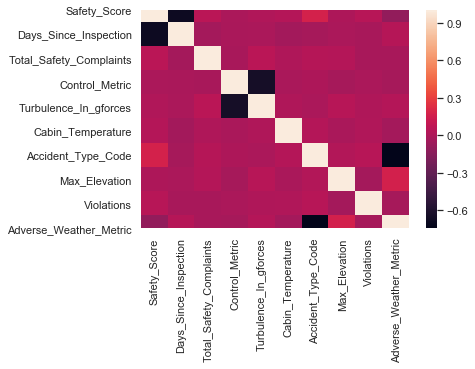

In [7]:
sns.heatmap(df2.corr())

In [8]:
X=X_trans
y=label
y_test=label
X_train=X
Y_train=y

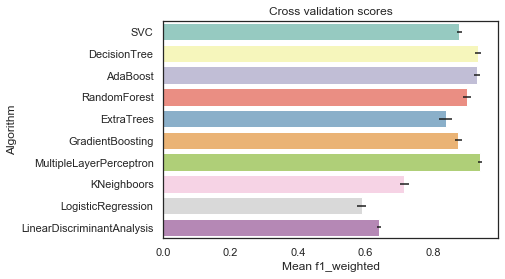

In [14]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X, y = y, scoring = "f1_weighted", cv = kfold, n_jobs=6))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean f1_weighted")
g = g.set_title("Cross validation scores")

In [12]:
#Multilayer Perceptron
MLP = MLPClassifier((100,30,4),learning_rate_init=0.01,alpha=1e-5,validation_fraction=.1)

mlp_param_grid = {'solver': ['sgd','adam'], 
              'max_iter': [1100,500,800,1200],
              'random_state':[6,7,8,9],
            'learning_rate':['constant', 'adaptive']
                 }

gsMlpC = GridSearchCV(MLP,param_grid = mlp_param_grid, cv=kfold, scoring="f1_weighted", n_jobs= 6, verbose = 1)

gsMlpC.fit(X,y)

MLP_best = gsMlpC.best_estimator_

# Best score
gsMlpC.best_score_

Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  9.2min


KeyboardInterrupt: 

In [11]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="f1_weighted", n_jobs= 6, verbose = 1)

gsadaDTC.fit(X,y)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done 716 tasks      | elapsed:    9.7s
[Parallel(n_jobs=6)]: Done 1120 out of 1120 | elapsed:   15.2s finished


In [ ]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["entropy"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="f1_weighted", n_jobs= 6, verbose = 1)

gsExtC.fit(X,y)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [4,8],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="f1_weighted", n_jobs= 6, verbose = 1)

gsRFC.fit(X,y)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

In [ ]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="f1_weighted", n_jobs= 6, verbose = 1)

gsGBC.fit(X,y)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

In [ ]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="f1_weighted", n_jobs= 6, verbose = 1)

gsSVMC.fit(X,y)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsMlpC.best_estimator_,"Multilayer Perceptron",X_train,Y_train,cv=kfold)

In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))
X_train=pd.DataFrame(X)
X_train.columns=df2.columns
names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),
                     ("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1]
        g = sns.barplot(y=X_train.columns[indices],x = classifier.feature_importances_[indices] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1
print(df2.columns)

In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(X), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(X), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(X), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(X), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(X), name="GBC")
test_Survived_MLP = pd.Series(MLP_best.predict(X), name="MLP")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,
                              test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC,test_Survived_MLP],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best),('mlp',MLP_best)], voting='soft', n_jobs=6)

votingC = votingC.fit(X_train,y)

In [ ]:
test_Survived = pd.Series(votingC.predict(X_test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("desktop/ensemble_python_voting.csv",index=False)

In [ ]:
"""kf = StratifiedKFold(n_splits=10)
clf = SVC(C=1,random_state=i)
#clf = MLPClassifier((100,30,4),learning_rate_init=0.01,alpha=1e-5,validation_fraction=.3,random_state=625)

for train_indices, test_indices in kf.split(X,y):
    clf.fit(X[train_indices], y[train_indices])
    y_pred=clf.predict(X_test)
    print(f1_score(y_test,y_pred,average='weighted'))"""


"""from tqdm import tqdm_notebook
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
alphas = np.logspace(-5, 3, 5)
names = ['alpha ' + str(i) for i in alphas]
for i in alphas:
    clf = MLPClassifier((100,30,4),learning_rate_init=0.01,alpha=1e-5,validation_fraction=.3,random_state=20)
    y_pred=clf.fit(X,y).predict(X_test)
    c=f1_score(y_test, y_pred, average='weighted')
    print(i,c)"""

"""from tqdm import tqdm_notebook
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.svm import SVC
#alphas = np.logspace(-5, 3, 5)
#names = ['alpha ' + str(i) for i in alphas]
a,b,v=0,0,0
for i in range(0,1000,25):
    #clf = MLPClassifier((100,30,4),learning_rate_init=0.01,alpha=1e-5,validation_fraction=.1,random_state=i)
    clf = SVC(C=1,random_state=i)
    y_pred=clf.fit(X,y).predict(X_test)
    c=f1_score(y_test, y_pred, average='weighted')
    a=a+c
    v=v+1
    print(i,v,c)
    if v>40:
        break
print(a/len(range(0,1000,25)))"""

In [8]:
df3 = pd.read_csv('ensemble_python_voting.csv')

In [10]:
df3['Severity']=pd.Series(le.inverse_transform(df3.Severity.values))

In [15]:
df3.to_csv('desktop/ensemble_python_voting.csv',index=False)